In [15]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

tf.executing_eagerly()

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
#preparing and loading dataset
test_data ,train_data, validation_data = tfds.load(name="qasc", split=["test", "train", "validation"], 
                                  batch_size=-1)
train_data

Version:  2.4.1
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


{'answerKey': <tf.Tensor: shape=(8134,), dtype=string, numpy=array([b'G', b'G', b'F', ..., b'A', b'H', b'D'], dtype=object)>,
 'choices': {'label': <tf.Tensor: shape=(8134, 8), dtype=string, numpy=
  array([[b'A', b'B', b'C', ..., b'F', b'G', b'H'],
         [b'A', b'B', b'C', ..., b'F', b'G', b'H'],
         [b'A', b'B', b'C', ..., b'F', b'G', b'H'],
         ...,
         [b'A', b'B', b'C', ..., b'F', b'G', b'H'],
         [b'A', b'B', b'C', ..., b'F', b'G', b'H'],
         [b'A', b'B', b'C', ..., b'F', b'G', b'H']], dtype=object)>,
  'text': <tf.Tensor: shape=(8134, 8), dtype=string, numpy=
  array([[b'an object', b'eukaryote', b'bacteria', ...,
          b'chlorofluorocarbons', b'Tobacco mosiac', b'prokaryote'],
         [b'birth', b'respiration', b'h2o', ..., b'massive damage',
          b'ozone depletion', b'Allergies'],
         [b'heat energy', b'movement', b'metriculation', ...,
          b'ejaculation', b'kinetic energy', b'sperm'],
         ...,
         [b'mitosis', b'repro

In [16]:
combinedFact = train_data['combinedfact']
question = train_data['question']
#parsing through json file to extract question and sentence pairs
print("Context Example")
print(combinedFact[:20])
print("Question Example")
print(question[:20])

Context Example
tf.Tensor(
[b'Tobacco mosaic is not a cell' b'ozone depletion puts children at risk'
 b'muscle contractions cause the ability of ejaculation'
 b'the atmosphere is essential to all living organisms'
 b'irradiating food prevents  spoilage'
 b'pugs breathe with the help of a diaphragm'
 b'Burning fossil fuels warms the atmosphere' b'heavy rains cause erosion'
 b'Jellyfish have a more complex nervous system.'
 b'Most protists are full and smooth'
 b'Many antibiotics affect small organelles where proteins are made'
 b'It is essential to observe the average weather in one place over time.'
 b'conserving water can be used for survival in a desert'
 b'threatening behavior by predators causes a rodent to extend its quills'
 b'Adult sea urchins have radial symmetry.'
 b'Glucose causes food to taste sweet.'
 b'Centrioles are organelles involved in mitosis.'
 b'storms cause the amount that lakes contain to increase'
 b'Arsenic compounds cause harm to living things'
 b'Specializatio

In [17]:
#cleaning question array and context array for easy tokenization, additionally appending start and end tokens for future decoder word generation

qarr = []
for q in list(question):
  qarr += ["START_ "+str(q.numpy()).strip('b\'?')+" _END"]

print(qarr)

carr = []
for c in list(combinedFact):
  carr += [str(c.numpy()).strip('b\'')]

print(carr)

['START_ What is not a cell _END', 'START_ what puts children at risk _END', 'START_ What do muscle contractions give the ability to happen _END', 'START_ What is essential to all living organisms _END', 'START_ Irradiating food prevents what _END', 'START_ What breathes with the help of a diaphragm _END', 'START_ What causes global warming _END', 'START_ Erosion can be caused by  _END', 'START_ Which of the following has the most complex nervous system _END', 'START_ what are full and smooth _END', 'START_ What affect small organelles where proteins are made _END', 'START_ To learn more about the average weather, it is essential to: _END', 'START_ Where is conserving water useful for survival _END', 'START_ What extends something because of threatening behavior by predators _END', 'START_ What has radial symmetry _END', 'START_ How does glucose cause food to taste _END', 'START_ What is involved in the cellular process of mitosis _END', 'START_ what cause the amount that lakes contain

In [18]:
#tokenization and encoding

myTokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True, oov_token = "<OOV>",filters = '!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')

myTokenizer.fit_on_texts(qarr)
numDecoderTokens = len(myTokenizer.word_index)
myTokenizer.fit_on_texts(carr)
numEncoderTokens = len(myTokenizer.word_index)
print(numEncoderTokens)
print(numDecoderTokens)

5770
4339


In [19]:
#useful stats for future layers

cmax = -1
for c in carr:
  c = c.split()
  if len(c) > cmax:
    cmax = len(c)
    
qmax = -1
for q in qarr:
  q = q.split()
  if len(q) > qmax:
    qmax = len(q)

print("This is the max length for questions", qmax)
print("This is the max length for combinedFacts", cmax)

This is the max length for questions 27
This is the max length for combinedFacts 27


In [20]:
#padding arrays all to the same length for better data comprehension
#creating decoder_target_data will let us refrecnce the vocabulary and occurences in strings

output_seq = myTokenizer.texts_to_sequences(qarr)
input_seq = myTokenizer.texts_to_sequences(carr)


encoder_input_data = np.array(keras.preprocessing.sequence.pad_sequences(input_seq, padding = 'post', dtype='float32'))
decoder_input_data = np.array(keras.preprocessing.sequence.pad_sequences(output_seq, padding = 'post', dtype='float32'))
decoder_target_data = np.zeros((len(qarr), qmax, numEncoderTokens+1), dtype='float32')

In [21]:
#iterating through decoder_input_data while creating a map of vocabulary being used in decoder_input_data so decoder lstm will understand which words to use

for i in range(8134):
  for j in range(27):
    if j>0:
      decoder_target_data[i, j-1, int(decoder_input_data[i][j])] = 1.

In [22]:
#example of padded sequences

encoder_input_data

array([[ 668., 2066.,    9., ...,    0.,    0.,    0.],
       [1066., 1122., 2625., ...,    0.,    0.,    0.],
       [ 462., 1365.,   18., ...,    0.,    0.,    0.],
       ...,
       [ 730.,   80.,   52., ...,    0.,    0.,    0.],
       [ 399.,   16.,  721., ...,    0.,    0.,    0.],
       [  90.,   10.,   22., ...,    0.,    0.,    0.]], dtype=float32)

In [23]:
#embedding size based off of max stats from earlier, shooting for roughly double
embedding_size = 50

#encoder relies on inputs and embedding, these two are passed down to the LSTM which returns a hidden state and cellstate
#hidden state and cell state contains useful information from learned sentences to pass to decoder
encoder_inputs = keras.Input(shape=(None,))
encoder_embedding=  keras.layers.Embedding(numEncoderTokens+1, embedding_size)(encoder_inputs)
encoder_lstm = keras.layers.LSTM(50, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

In [24]:
#same formatting of input for decoder
#decoder recieves hidden + cell states from encoder and start understanding the relation between sentence to question
#disregard hidden state and cell state because now we want an output
#decoder dense will take word outputs from decoder lstm and create a list of most probable words in list of vocabulary based on context of question

decoder_inputs = keras.Input(shape=(None,))
decoder_embedding = keras.layers.Embedding(numEncoderTokens+1, embedding_size)
decoder_embedded_inputs = decoder_embedding(decoder_inputs)
decoder_lstm = keras.layers.LSTM(50, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedded_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(numEncoderTokens+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [25]:
#compiling model and using categorical crossentropy for previous dense layer and then printing model structure

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 50)     288550      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 50)     288550      input_4[0][0]                    
____________________________________________________________________________________________

In [26]:
#training and fitting data

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=64, epochs=100, validation_split=.05)

Epoch 1/100
121/121 [==============================] - 14s 90ms/step - loss: 5.4793 - acc: 0.6373 - val_loss: 2.1607 - val_acc: 0.6669
Epoch 2/100
121/121 [==============================] - 10s 83ms/step - loss: 2.0722 - acc: 0.6751 - val_loss: 1.8810 - val_acc: 0.7285
Epoch 3/100
121/121 [==============================] - 11s 87ms/step - loss: 1.8697 - acc: 0.7230 - val_loss: 1.8274 - val_acc: 0.7298
Epoch 4/100
121/121 [==============================] - 10s 87ms/step - loss: 1.8121 - acc: 0.7258 - val_loss: 1.8001 - val_acc: 0.7356
Epoch 5/100
121/121 [==============================] - 10s 86ms/step - loss: 1.7690 - acc: 0.7333 - val_loss: 1.7755 - val_acc: 0.7397
Epoch 6/100
121/121 [==============================] - 10s 85ms/step - loss: 1.7172 - acc: 0.7387 - val_loss: 1.7505 - val_acc: 0.7436
Epoch 7/100
121/121 [==============================] - 11s 88ms/step - loss: 1.6917 - acc: 0.7407 - val_loss: 1.7306 - val_acc: 0.7439
Epoch 8/100
121/121 [==============================] - 

In [27]:
#saving to avoid training again

model.save(filepath='./saved_model/')

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [28]:
#for text generation on the encoder end we need the previous encoder states, and the inputs

encoderModel = keras.Model(encoder_inputs, encoder_states)
encoderModel.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 50)          288550    
_________________________________________________________________
lstm_2 (LSTM)                [(None, 50), (None, 50),  20200     
Total params: 308,750
Trainable params: 308,750
Non-trainable params: 0
_________________________________________________________________


In [29]:
#copying same decoder model from before with new compilation

decoder_state_input_h = keras.Input(shape=(50,))
decoder_state_input_c = keras.Input(shape=(50,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedded_inputs2= decoder_embedding(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_embedded_inputs2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)
decoder_model = keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs2] + decoder_states2)


In [30]:
#function takes in sentence of shape (1,1,len(sentence))
#gain relevant information from sentence encoded
#kickstart text generation with previous start token embeddings
#write most probable word from decoder dense to decoded sentence
#if the length becomes too long we want to cut it off

def decode_sequence(input_seq):
  states_value = encoderModel.predict(input_seq)
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = myTokenizer.word_index.get('start_')


  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    most_probable_word = np.argmax(output_tokens[0, -1, :])
    decoded_word = myTokenizer.index_word.get(most_probable_word)
    #print(decoded_word)
    decoded_sentence += ' '+decoded_word

    if (decoded_word == '_end' or
      len(decoded_sentence) > 52):
      stop_condition = True

    #moving onto next word
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = most_probable_word

   # update states so we dont generate same word again
    states_value = [h, c]

  return decoded_sentence

In [37]:
#printing sentence we're going to work with

example = 101
print(carr[example])
print(encoder_input_data[example])

the flow of heat into the system causes thermal expansion
[   5.  248.    8.   35.   29.    5.   57.   23.  680. 1072.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.]


In [38]:
#print question for reference

print(qarr[example])
print(decoder_input_data[example])

START_ he flow of heat into the system causes what _END
[2.000e+00 2.111e+03 2.480e+02 8.000e+00 3.500e+01 2.900e+01 5.000e+00
 5.700e+01 2.300e+01 4.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]


In [39]:
#print question generated from model


input_seq = encoder_input_data[example:example+1]
#print(input_seq)
decoded_sentence = decode_sequence(input_seq)

print(decoded_sentence)

 what can cause an object to produce light _end


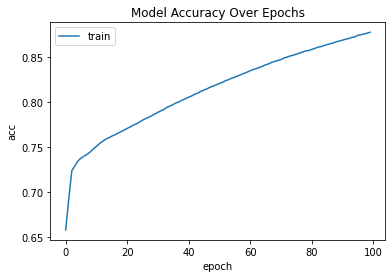

In [34]:
plt.plot(history.history["acc"])
plt.title("Model Accuracy Over Epochs")
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train'], loc ='upper left')
plt.show()

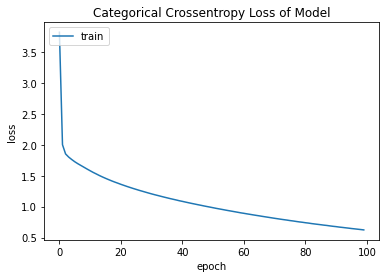

In [35]:
plt.plot(history.history["loss"])
plt.title("Categorical Crossentropy Loss of Model")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc ='upper left')
plt.show()